In [1]:
# Importing relevant libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Display an image from a local file
img__scheme = "molecules.png"

# Table of Contents

1. [Introduction](#introduction)
2. [System Description](#system-description)
3. [Properties](#props)
    1. [Aspen PLUS](#aspen-phys)
    2. [Hydrogen Solubility: Extrapolation of literature data](#h2-extrapolation)
    3. [Hydrogen Solubility: Sensitivity Analysis](#h2-sensitivity)
4. [Diffusion of Hydrogen to Catalyst Surface](#diffusion-cat-surf)
    1. [Mean Void Fraction](#mean-void-frac)   
    2. [Influence of Pellet Geometry on Mean Void Fraction](#mean-void-frac-sensitivity)      

<a id="introduction"></a>
# Introduction

Unsaturated fatty alcohols are valuable products derived from the hydrogenolysis of fatty acid methyl esters (FAME), with applications in detergents, leather processing, and as industrial lubricants. Industrially, these alcohols are typically produced in slurry-type or fixed-bed trickle reactors. The fixed-bed trickle technology employs zinc chromate catalysts in the form of 3 mm pellets, operating under conditions of 230 bar and temperatures ranging from 270 to 300 °C.

In my dissertation project, the focus is on developing a novel catalyst to replace zinc chromate, aiming to improve efficiency and sustainability. During the research, data was collected on approximately 60 different materials. The reaction mechanism involves hydrogen dissolving in the FAME, diffusing through the liquid to the catalyst surface, and then reacting at the surface. Although the detailed description of each step is complex, this document provides a mathematical and conceptual overview of the entire process.

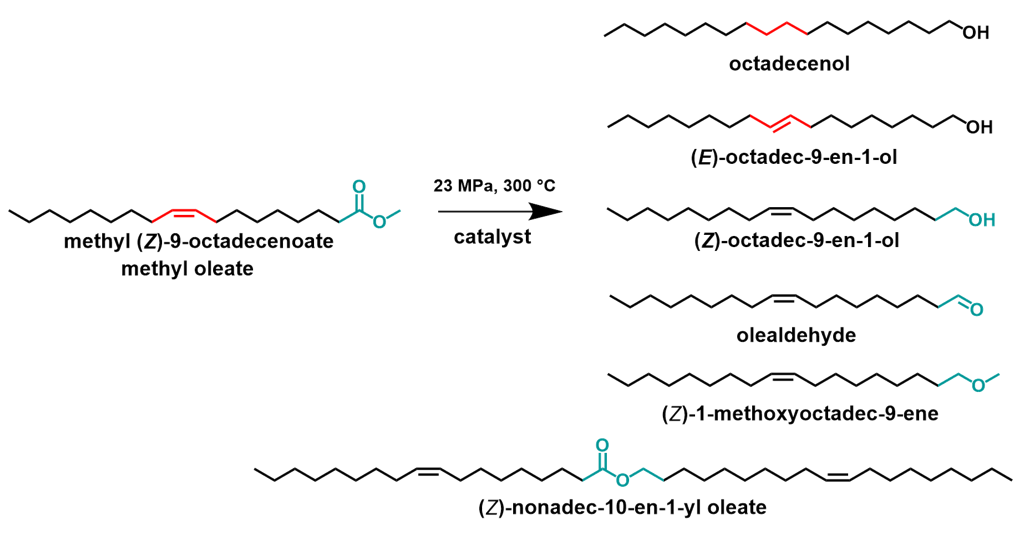

In [2]:
Image(filename=img__scheme, width=750, height=200)

<a id="system-description"></a>
# System Description
### Reactants

| **Reactant**        | **Formula**  | **Configuration**   |
|---------------------|--------------|---------------------|
| Methyl Oleate        | C₁₉H₃₆O₂     | cis (C18:1)         |
| Methyl Palmitate     | C₁₇H₃₄O₂     | Saturated (C16:0)   |
| Methyl Stearate      | C₁₉H₃₈O₂     | Saturated (C18:0)   |
| Methyl Linoleate     | C₁₉H₃₄O₂     | cis (C18:2)         |
| Hydrogen             | H₂           | -                   |

### Products

| **Product**         | **Formula**  | **Configuration**   |
|---------------------|--------------|---------------------|
| Oleylalcohol         | C₁₈H₃₆O      | cis (C18:1)         |
| Elaidylalcohol       | C₁₈H₃₆O      | trans (C18:1)       |
| Cetylalcohol         | C₁₆H₃₄O      | Saturated (C16:0)   |
| Stearylalcohol       | C₁₈H₃₈O      | Saturated (C18:0)   |
| Methanol             | CH₄O         | -                   |

In [3]:
# Reaction Conditions
p = 230 # [bar]
T = 270 # [°C]

# Flowrates
V_cm3 = 27.5 # [cm3/h] volumetric flow through the plug flow reactor
V_gas = 0.4 # [Nm3/h] volumetric flow through the plug flow reactor

# Reactor geometry
d_tube = 0.02 # [m] reactor inner diameter
d_thermowell = 0.005 # [m] thermowell tube outer diameter
A = math.pi*((d_tube/2)**2-(d_thermowell/2)**2) # [m2] effective cross-sectional area

# Catalyst
m_cat = 144 # [g] arbitrary number
A_cat = 44 # [m2/g] specific surface of the catalyst, arbitrary

# Catalyst bed
V = 120 # [cm3] Catalyst bed volume

<a id="props"></a>
# Properties
<a id="aspen-phys"></a>
##  Aspen Plus

Due to the limited availability of experimental data, an Aspen simulation was conducted to estimate the chemical properties of the system's components. The simulation employed the NRTL method for activity coefficients and the Wilke-Chang-Lee method for diffusivity. The following properties were simulated:
- Density
- Viscosity
- H2 Diffusivity
- H2 Solubility

In [4]:
# Load data from the Excel sheet with Aspen Output
df_prop=pd.read_excel("Aspen Output 3.xlsx", sheet_name="master")
df_h2_sol=pd.read_excel("Aspen Output 3.xlsx", sheet_name="Solubility_mass")
# Save it to csv
df_h2_sol.to_csv("h2_sol.csv")

In [5]:
# Example renaming dictionary: {'old_column_name': 'new_column_name'}
rename_dict = {
    'METHYL-OLEATE': "_MeOleate",
    'METHYL-ELAIDATE': "_MeElaidate",
    'METHYL-STEARATE': "_MeStearate",
    'METHYL-PALMITATE': "_MePalmitate",
    '9-OCTADECEN-1-OL.-(Z)-':"_OleylAlcohol",
    'ELAIDYL-ALCOHOL':"_ElaidylAlcohol",
    '1-OCTADECANOL':"_StearylAlcohol",
    '1-HEXADECANOL':"_CetylAlcohol",
    'LINOLEYL-ALCOHOL':"_LinoleylAlcohol",
    'METHYL-LINOLEATE':"_MeLinoleate",
    "METHANOL":"_Methanol",
    'HYDROGEN':"_H2"
}
# Rename columns in df_prop
df_prop = df_prop.rename(columns=rename_dict)

In [6]:
# List of components (these are the column names in your dataframe for the respective components)
components = ['_MeOleate', '_MeElaidate', '_MeStearate', '_MePalmitate', 
              '_OleylAlcohol', '_ElaidylAlcohol', '_StearylAlcohol', 
              '_CetylAlcohol', '_Methanol', '_H2']

# List of available properties (this list can be extended as needed)
available_properties = df_prop["Property"].unique()

# Function to get a specific property (e.g., density, viscosity) based on temperature and pressure
def get_property(df, temp, pres, property_type):
    if property_type not in available_properties:
        raise ValueError(f"Property {property_type} is not available. Choose from {available_properties}")

    property_values = {}
    for component in components:
        # Filter by property type, temperature, and pressure
        row = df[(df['Property'] == property_type) & (df['TEMP_C'] == temp) & (df['PRES_bar'] == pres)]
        if not row.empty:
            # Store the property value in the dictionary using a key format like 'rho_MeOleate' or 'visc_MeOleate'
            property_values[f'{property_type.split("_")[0]}{component}'] = row[component].values[0]
        else:
            property_values[f'{property_type.split("_")[0]}{component}'] = None  # If no match is found
    
    return property_values

# Example usage:
# df_prop is your dataframe, temp is the temperature, and pres is the pressure
temperature = 270  # Example temperature
pressure = 230     # Example pressure

# Get density (rho_kg/m3) for all components at the specified temperature and pressure
property_type = 'H2_diff_in_m2/s'  # You can change this to any other property like 'cp_liq_kJ/kg-K', 'visc_Pa_sec', etc.
property_dict = get_property(df_prop, temperature, pressure, property_type)

# Show the results
for key, value in property_dict.items():
    print(f"{key}: {value}")


H2_MeOleate: 3.55085074767468e-08
H2_MeElaidate: nan
H2_MeStearate: nan
H2_MePalmitate: nan
H2_OleylAlcohol: 1.88188833142571e-08
H2_ElaidylAlcohol: nan
H2_StearylAlcohol: nan
H2_CetylAlcohol: nan
H2_Methanol: nan
H2_H2: nan


<a id="h2-extrapolation"></a>
## Hydrogen Solubility: Extrapolation of literature data

To verify the hydrogen solubility, the simulated solubility was compared to data reported in the literature.

This code fits experimental data from the literature representing the relationship between pressure and solubility of a substance. The experimental data consists of pressure values (in MPa) and corresponding solubility values.

<small>Source:<small/>
    
<small>_Zhang X, Dong T, Wu Z, Jing Y, Yu D, Zhang H, Du J, Wang L. Soybean Oil Treatment Using the Dissolving Curve Equation of Hydrogen. J Oleo Sci. 2021 Sep 4;70(9):1231-1238. doi: 10.5650/jos.ess21065. Epub 2021 Aug 6. PMID: 34373403._<small/>


### Data Fitting

Using polynomial regression, the code fits a polynomial curve to the experimental data. The degree of the polynomial can be adjusted to best fit the data. The fitted curve represents the relationship between pressure and solubility based on the experimental data.

### Extrapolation

After fitting the polynomial curve, the code provides a function to extrapolate solubility values for pressure values beyond those present in the experimental data. This extrapolation allows us to estimate the solubility of the substance at higher pressure levels, which may not have been directly measured in the experiments.

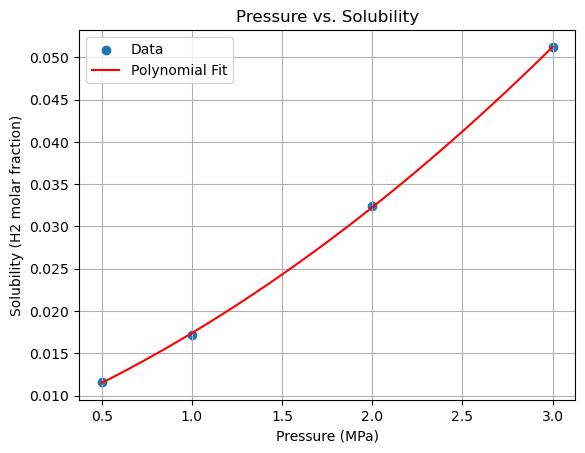

In [7]:
# Given data
pressures = np.array([0.5, 1.0, 2.0, 3.0])  # Pressure in MPa
solubilities = np.array([0.0116, 0.0172, 0.0324, 0.0512])  # Solubility

# Fit polynomial curve
degree = 2  # Degree of the polynomial (you can adjust this)
coefficients = np.polyfit(pressures, solubilities, degree)
poly_fit = np.poly1d(coefficients)

# Generate points for plotting the curve
pressure_range = np.linspace(min(pressures), max(pressures), 100)
solubility_fit = poly_fit(pressure_range)

# Plot the data and the fitted curve
plt.scatter(pressures, solubilities, label='Data')
plt.plot(pressure_range, solubility_fit, color='red', label='Polynomial Fit')
plt.xlabel('Pressure (MPa)')
plt.ylabel('Solubility (H2 molar fraction)')
plt.title('Pressure vs. Solubility')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Plugging in the experimental codnitions of the conducted experiments:
# Generate points for plotting the curve
def extrapolate_pressure_to_solubility(pressure, coefficients):
    """
    Extrapolate solubility based on pressure using a polynomial fit.

    Args:
        pressure (float or array-like): Pressure value(s) to extrapolate.
        coefficients (array-like): Coefficients of the polynomial fit.

    Returns:
        float or array-like: Extrapolated solubility value(s).
    """
    # Create polynomial function from coefficients
    poly_fit = np.poly1d(coefficients)
    
    # Extrapolate solubility
    solubility = poly_fit(pressure)
    
    return solubility

pressure_to_extrapolate = 23  # Pressure to extrapolate
extrapolated_solubility = extrapolate_pressure_to_solubility(pressure_to_extrapolate, coefficients)
print(f"At pressure={pressure_to_extrapolate} MPa, extrapolated solubility={extrapolated_solubility}")
print("The extrapolation provided solubility above reasonable limit.")

At pressure=23 MPa, extrapolated solubility=1.290897487437185
The extrapolation provided solubility above reasonable limit.


<a id="h2-sensitivity"></a>
## Hydrogen Solubility: Sensitivity Analysis

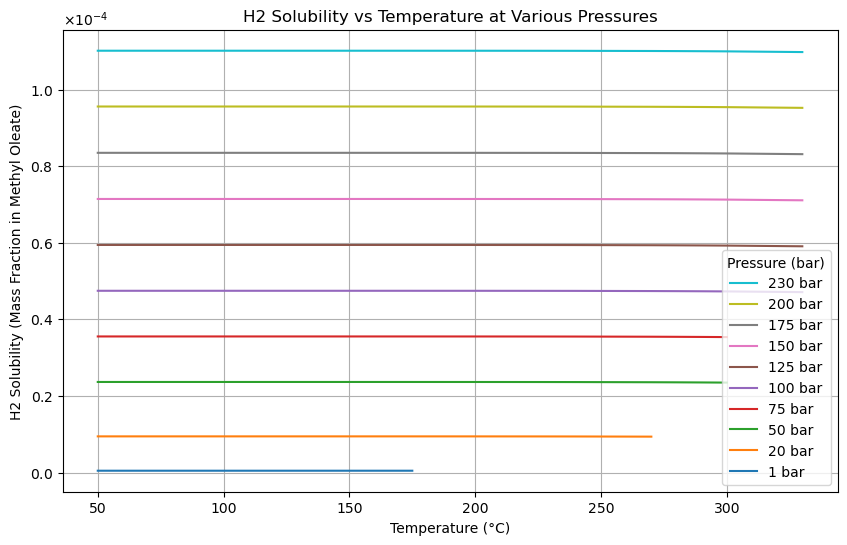

In [9]:
# Group data by pressure
pressures = df_h2_sol['PRES_bar'].unique()

# Plot solubility for each pressure
plt.figure(figsize=(10, 6))

lines = []
labels = []

# Plot and store lines and labels
for pressure in pressures:
    subset = df_h2_sol[df_h2_sol['PRES_bar'] == pressure]
    line, = plt.plot(subset['TEMP_C'], subset['H2FRA_mass_Me_Oleate'], label=f'{pressure} bar')
    lines.append(line)
    labels.append(f'{pressure} bar')

# Add labels and title
plt.xlabel('Temperature (°C)')
plt.ylabel('H2 Solubility (Mass Fraction in Methyl Oleate)')
plt.title('H2 Solubility vs Temperature at Various Pressures')

# Reverse the order of lines and labels for the legend
plt.legend(lines[::-1], labels[::-1], title='Pressure (bar)')

# Format y-axis in scientific notation
ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.grid(True)

# Show the plot
plt.show()

And less of the temperature:

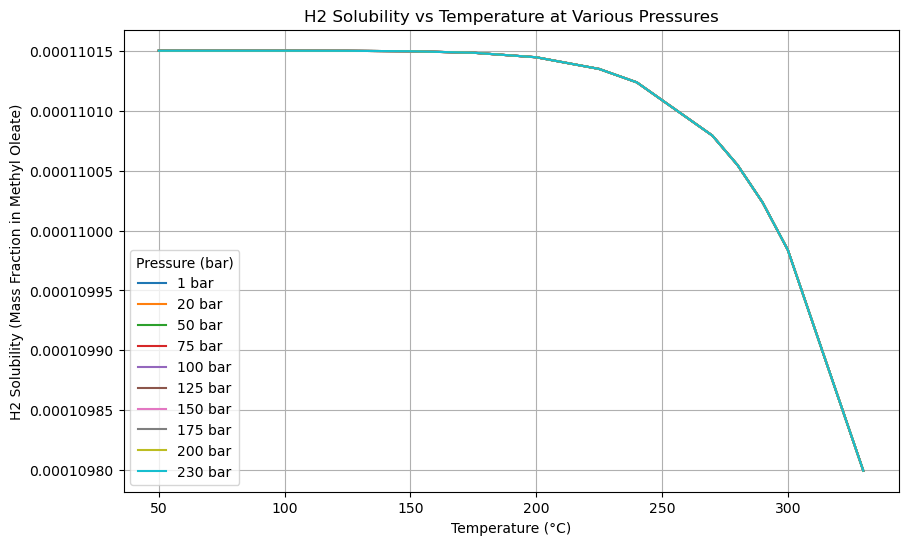

Diffusivity simulated in Aspen PLUS is considered for fruther calculations.


In [10]:
# Group data by pressure
pressures = df_h2_sol['PRES_bar'].unique()

# Plot solubility for each pressure
plt.figure(figsize=(10, 6))

for pressure in pressures:
    subset = df_h2_sol[df_h2_sol['PRES_bar'] == 230]
    plt.plot(subset['TEMP_C'], subset['H2FRA_mass_Me_Oleate'], label=f'{pressure} bar')

# Add labels and title
plt.xlabel('Temperature (°C)')
plt.ylabel('H2 Solubility (Mass Fraction in Methyl Oleate)')
plt.title('H2 Solubility vs Temperature at Various Pressures')
plt.legend(title='Pressure (bar)')
plt.grid(True)

# Show the plot
plt.show()

print("Diffusivity simulated in Aspen PLUS is considered for fruther calculations.")

<a id="diffusion-cat-surf"></a>
## Diffusion of Hydrogen to Catalyst Surface
<a id="mean-void-frac"></a>
### Mean Void Fraction

Correlation used for estimation of the catalyst bed void fraction:

$$
\epsilon_{\text{mean}} = 0.293 + 0.684 d_r^{-0.85} \frac{1}{\sqrt{1.837 d_r - 1}}
$$

<small>Source:<small/>

<small>_Foumeny, E. A., & Roshani, S. (1991). Mean voidage of packed beds of cylindrical particles. Chemical Engineering Science, 46(9), 2363–2364. doi:10.1016/0009-2509(91)85135-k_<small/>



In [11]:
# Real cyllindrical pellet dimensions
d_cp = 0.003 # [m] diameter cylindrical pellet
h_cp = 0.003 # [m] height cyllindrical pellet
V_cp = math.pi*((d_cp/2)**2)*h_cp

# Calculating equivalent sphere diameter
d_pe = 2*(3*V_cp/(4*math.pi))**(1/3) # [m] equivalent sphere diameter

# Calculating dr
dr = d_tube/d_pe # [m] reduced diameter

# Calculating epsilon_mean
epsilon_mean = 0.293+0.684*(dr**(-0.85))*(1/((1.837*dr-1)**(0.5)))

print(f"Mean void fraction of the packed bed is {epsilon_mean:.3f}.")

Mean void fraction of the packed bed is 0.342.


<a id="mean-void-frac-sensitivity"></a>
### Influence of Pellet Geometry on Mean Void Fraction
Catalyst particle is simplified as a cylinder, where diffusion occurs only towards lateral face.

In [12]:
# Given dimensions
diameter = 3  # in mm
height = 3    # in mm

# Calculate the radius
radius = diameter / 2

# Calculate the area of one end (circular base)
area_end = math.pi * (radius ** 2)

# Calculate the surface area of the cylindrical body
area_body = 2 * math.pi * radius * height

# Calculate the total area of both ends
total_area_ends = 2 * area_end

# Calculate the total surface area of the cylinder
total_surface_area = area_body + total_area_ends

# Print the results
print(f"Radius: {radius:.2f} mm")
print(f"Area of one end: {area_end:.2f} mm2")
print(f"Surface area of the body: {area_body:.2f} mm2")
print(f"Total area of both ends: {total_area_ends:.2f} mm2")
print(f"Total surface area: {total_surface_area:.2f} mm2")

# The particle geometry is then to be simplified as a cylindrical shape, without diffusion on its ends.
# Contribution to the surface is included in elongation of the particle

l_new = total_surface_area/(math.pi*2*radius) # [mm] new length of the particle with compensation for ends

# Particle geometry revisited --> This is with respect to the simplified assumption in the code block before
dp = 0.003  # [m] particle diameter
height = l_new/1e3   # [m]

Radius: 1.50 mm
Area of one end: 7.07 mm2
Surface area of the body: 28.27 mm2
Total area of both ends: 14.14 mm2
Total surface area: 42.41 mm2


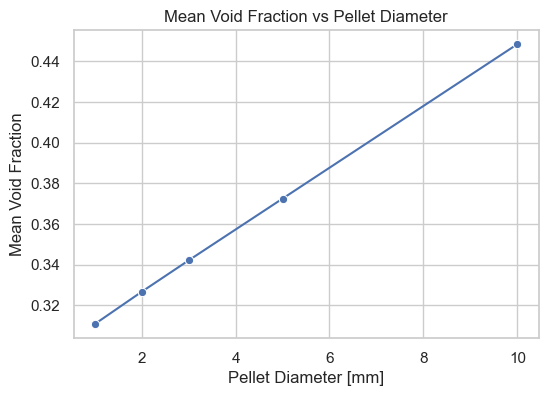

In [13]:
# Define constants for pellet height and tube diameter
h_cp = 0.003  # [m] height cylindrical pellet
d_tube = 0.02  # [m] tube diameter (assuming it's a constant value for analysis)

# Define a list of d_cp values for sensitivity analysis
d_cp_values = [0.001, 0.002, 0.003, 0.005, 0.010]  # You can specify any values you want

# Initialize a list to store the results
results = []

# Loop over the d_cp values
for d_cp in d_cp_values:
    # Recalculate volume of cylindrical pellet and equivalent sphere diameter
    V_cp = math.pi * ((d_cp / 2) ** 2) * h_cp
    d_pe = 2 * (3 * V_cp / (4 * math.pi)) ** (1 / 3)  # [m] equivalent sphere diameter

    # Calculate reduced diameter (dr)
    dr = d_tube / d_pe

    # Calculate epsilon_mean
    epsilon_mean = 0.293 + 0.684 * (dr ** (-0.85)) * (1 / ((1.837 * dr - 1) ** (0.5)))

    # Store the results in the list
    results.append({"d_cp": d_cp, "epsilon_mean": epsilon_mean})

# Convert the results to a Pandas DataFrame
df = pd.DataFrame(results)
df["d_cp"] = df["d_cp"]*1e3 # Conversion from m to mm

# Plotting the results using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.lineplot(x="d_cp", y="epsilon_mean", data=df, marker="o")
plt.title("Mean Void Fraction vs Pellet Diameter")
plt.xlabel("Pellet Diameter [mm]")
plt.ylabel("Mean Void Fraction")
plt.grid(True)
plt.show()


Influence of pellet height on mean void fraction:

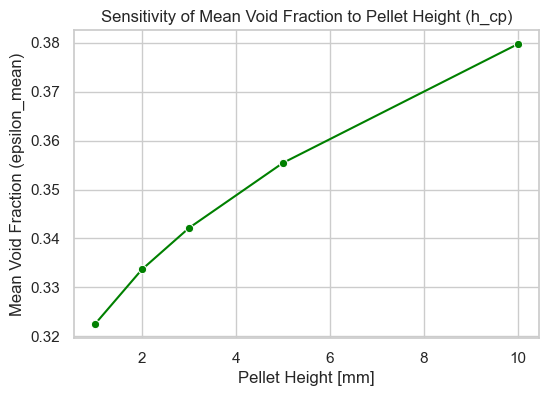

In [14]:
# Define constants for pellet diameter and tube diameter
d_cp = 0.003  # [m] diameter cylindrical pellet (constant for this analysis)
d_tube = 0.02  # [m] tube diameter (assuming it's a constant value for analysis)

# Define a list of h_cp values for sensitivity analysis
h_cp_values = [0.001, 0.002, 0.003, 0.005, 0.010]  # You can specify any values you want

# Initialize a list to store the results
results = []

# Loop over the h_cp values
for h_cp in h_cp_values:
    # Recalculate volume of cylindrical pellet and equivalent sphere diameter
    V_cp = math.pi * ((d_cp / 2) ** 2) * h_cp
    d_pe = 2 * (3 * V_cp / (4 * math.pi)) ** (1 / 3)  # [m] equivalent sphere diameter

    # Calculate reduced diameter (dr)
    dr = d_tube / d_pe

    # Calculate epsilon_mean
    epsilon_mean = 0.293 + 0.684 * (dr ** (-0.85)) * (1 / ((1.837 * dr - 1) ** (0.5)))

    # Store the results in the list
    results.append({"h_cp": h_cp, "epsilon_mean": epsilon_mean})

# Convert the results to a Pandas DataFrame
df = pd.DataFrame(results)
df["h_cp"] = df["h_cp"]*1e3 # Conversion from m to mm

# Plotting the results using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.lineplot(x="h_cp", y="epsilon_mean", data=df, marker="o", color = "green")
plt.title("Sensitivity of Mean Void Fraction to Pellet Height (h_cp)")
plt.xlabel("Pellet Height [mm]")
plt.ylabel("Mean Void Fraction (epsilon_mean)")
plt.grid(True)
plt.show()


### Estimation of a pressure drop over the Catalyst bed
#### Gas phase

Ergun equation (11.5.1-3):
$$
-\frac{dp_t}{dz} = f \frac{\rho_g u_s^2}{d_p}
$$

For symplification, the properties are deemed constant.

<small>Source:<small/>

<small>_Froment GF, DeWilde J, Bischoff KB. Chemical reactor analysis and design. 3rd ed. Hoboken: Wiley; 2011._<small/>

In [15]:
rho_h2 = (p*1e5/(8.314*(T+273.15)*2))/1e3 # [kg/m3] Hydrogen density 
us_h2 = (V_gas/(A*epsilon_mean))/3600 # [m/s] Hydrogen superficial velocity 

Friction factor for a highly turbulent flow (11.5.1-12):
$$
f = 1.75 \cdot \frac{1 - \epsilon}{\epsilon^3}
$$
<small>Source:<small/>

<small>_Froment GF, DeWilde J, Bischoff KB. Chemical reactor analysis and design. 3rd ed. Hoboken: Wiley; 2011._<small/>

In [16]:
f_h2 = 1.75*(1-epsilon_mean)/(epsilon_mean**3) # Friction factor

In [17]:
pdrop = (f_h2*(rho_h2*(us_h2**2))/dp)*0.12 # [Pa]
pdrop

1994.651469358657

In [18]:
# Surface of solid per volume of the catalyst bed
av = m_cat*A_cat
# Sphere with equivalent surface area per volume as the actual particle
dp = 6*(1-epsilon_mean)/av

### Characterization of Liquid Phase
Ina  trickle bed reacttor, liquid phase and gas phase needs to be characterized separately. Due to the high difference in H2 and substrate flowrates, we will focus solely on the liquid phas. First of all it is necessary to determine liquid holdup. The experimental reactor did not include any experimental technique for measuring such, therefore we need to resort to an empirical correlation.

### Reynolds number


$$
Re = \frac{d_p \cdot G}{\mu}
$$


In [19]:
# Fetch properties
rho_re = get_property(df_prop, T, p, 'rho_kg/m3')
# Superficial velocity 
V = V_cm3*1e-6/3600 # [m3/s] volumetric flow through the plug flow reactor
rho_MeOleate = rho_re.get("rho_MeOleate") # [kg/m3] density of FAME
print(f"Density is {rho_MeOleate:.3f} kg/m3.")
m = V*rho_FAME # [kg/s] mass flow
# Assuming that the thickness of substrate layer over the catalyst peletts is negligable:
G = m/(A*epsilon_mean) # [kg/m2 s] superficial mass flow through the reactor, considering mean void fraction.
mu_re = get_property(df_prop, T, p, 'visc_Pa_sec')
mu_MeOleate = mu_re.get('visc_MeOleate') # [N/m2 S] dynamic viscosity
print(f"Dynamic viscosity is {mu_MeOleate:.4f} Pa*s.")
# Reynolds Number
Re = dp*G/mu_FAME # [dimensionless] Reynolds number
print(f"Re is {Re:.3f}.")

Density is 678.124 kg/m3.


NameError: name 'rho_FAME' is not defined

In [ ]:
df_prop["Property"].unique()

In [ ]:
# Given that Re < 190, jD = 0.983*Re**(-0.41)
jD = 0.983*Re**(-0.41) # [dimensionless] factor


# Calculate Schmidt number (Sc)
Sc = mu_MeOleate / (rho_MeOleate * diff_H2_MeOleate)
print(f"Schmidt Number is {Sc:.3f}.")

# Frössling Correlation
# Sh = 2 +0.6*Re**0.5*Sc**1/3

Sh = 2 +0.6*Re**0.5*Sc**1/3
print(f"Sherwood Number is {Sh:.3f}.")
print(f"Reynolds Number is {Re:.3f}.")

In [ ]:
# Mass transfer calculation from the Sherwood number
# Sh = km/(DH2_svnt/dp)
km = Sh*(diff_H2_MeOleate/dp) # [m/s]

print(f"km is {km:.3f} m/s.")

## Transport inside the catalyst particle

### Continuum model
#### First we need estimation of tortuosity
Bruggeman Relation:
tau = epsilon**n # n is 0.5 for random pore structures

In [ ]:
n_tort = 0.5
# Estimation of Porosity
# Volume of catalyst particle

# Define the dimensions of the pellet
diameter = 3.0  # in mm
height = 3.0    # in mm

# Calculate the radius
radius = diameter / 2.0

# Calculate the volume of the cylinder (pellet)
volume = math.pi * radius**2 * height 

# Experimental data
volume_water = 0.37 # [cm3/g] pore volume measured by water abosrption
density = 0.870 # [g/cm3]
epsilon_pore = volume_water*density
print(f"Porosity is {epsilon_pore:.3f}.")

tau = epsilon_pore**0.5

print(f"Tortuosity is {tau:.3f}.")

#### First we need estimation of tortuosity
To calculate the effective diffusivity, we must add contribution of molecular diffusion as well as knudsen diffusion:

1/Deff = 1/D_bulk + 1/D_knudsen 

In [ ]:
### Simplified properties

# Density 
rho_MeOleate = 678.1239 # [kg/m3]
rho_OleylAlcohol =  684.1543 # [kg/m3]
rho_Methanol = 277.9787 # [kg/m3]

# Viscosity 
mu_MeOleate = 0.000260794 # [Pa*s]
mu_OleylAlcohol =  0.00046826 # [Pa*s]
mu_Methanol = 0.00010166 # [Pa*s]

# Diffusivity
diff_H2_MeOleate = 0.0000171410226855357 # [cm2/s]

In [ ]:
# Diffusivity in bulk for the hydrogen entering pore

# Fuller-Schettler-Giddings equation could be a possible way how to assess it

# Knudsen Diffusion
r_pore = 11e-8 # [m] pore radius H210604M --> Hg Porosimetry evaluation
R = 8.314 # [kg⋅m2⋅s−2⋅K−1⋅mol−1] gas constant
T = 273.15 + 270 # [°C] temperatur ein the system
M_H2 = 2e-3 # [kg/mol] molar mass of diffusing species
p = 23e6 # [Pa] pressure

Dknd = (2/3)*(r_pore*((8*R*T/(math.pi*M_H2))**0.5)) # [m2/s]

# Effective diffusion
inverse_Deff = (epsilon_pore/tau)*(1/(diff_H2_MeOleate/1e4)+1/Dknd)
Deff = 1 / inverse_Deff

print(f"Bulk diffusivity is {(diff_H2_MeOleate/1e4):.4e}.")
print(f"Knudsen diffusion is {Dknd:.4e}.")
print(f"Effective diffusion is {Deff:.4e}.")

### Conclusion

Bulk diffusion is dominant factor, Knudsen diffusion does not play a significant role

## Adsorption of hydrogen and FAME to the catalyst surface

Steady state assumption
rads = rreaction = rdes

## Reaction of hydrogen and FAME on the catalyst surface

r = k1*c_MeOleate*p_H2**2-k2*c_OleylAlcohol [h-1]

In [ ]:
V_reactor = 120 # [cm3] Reactor volume
t_res_h = V_reactor/V_cm3 # [h] residence time
t_res_min = t_res_h*60 # [min] residence time
t_res_s = t_res_h*3600 # [s] residence time

In [ ]:
mass_flowrate = V_cm3*rho_MeOleate/1e3 # [g/h] mass flowrate of MeOleate
mol_flowrate = mass_flowrate/296.5 # [mol/h] molar flowrate of MeOleate
mol_flowrate_s = mol_flowrate/3600
C_MethylOleate = mol_flowrate/(V_cm3/1e3)

In [ ]:

# Define the reaction rate constant

k1 = 1e3*math.exp(-8600/(T)) # [h-1 atm-2] --> source Turek
k2 = 1e9*math.exp(-13100/(T)) # [h-1] --> source Turek

# Define initial conditions and parameters
C_MethylOleate = C_MethylOleate   # Initial concentration of A in mol/L

F_A0 = mol_flowrate_s  # Molar flow rate in mol/s
V_total = 0.120  # Total volume of reactor in L

# Define the differential equation (PFR model)
def pfr_model(V, C_A):
    # Reaction rate equation (first-order reaction)
    r_A = k1*C_MethylOleate*(p/1e5)/-k1 * C_A
    # Differential equation for concentration as a function of volume
    dC_A_dV = r_A / F_A0
    return dC_A_dV

# Set up integration range (reactor volume)
V_range = [0, V_total]  # from V=0 to V=V_total

# Solve the ODE using solve_ivp
solution = solve_ivp(pfr_model, V_range, [C_MethylOleate], t_eval=np.linspace(0, V_total, 100))

# Plot the results
plt.plot(solution.t, solution.y[0], label="Concentration of A")
plt.xlabel("Reactor Volume (L)")
plt.ylabel("Concentration of A (mol/L)")
plt.title("Concentration Profile in a Plug Flow Reactor")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt

# Constants and parameters
R = 1e-3# Radius of the catalyst particle (in meters)
Deff = 1e-9# Effective diffusivity of hydrogen in FAME (in m^2/s)
k = 1e-3# Reaction rate constant (in 1/s)
C_surf = 1.0# Surface concentration of hydrogen (in mol/m^3)
# Define the differential 
equationsdefodes(r, C):
    dCdr = C[1]
    d2Cdr2 = -2/r * C[1] - (k/Deff) * C[0]
    return np.vstack((dCdr, d2Cdr2))

# Boundary conditionsdefbc(Ca, Cb):
    return np.array([Ca[0] - C_surf, Cb[1]])

# Initial guess for the solution
r = np.linspace(1e-6, R, 100)
C_guess = np.zeros((2, r.size))
C_guess[0, :] = C_surf

# Solve the boundary value problem
sol = solve_bvp(odes, bc, r, C_guess)

# Concentration profile
C_profile = sol.sol(r)[0]

# Calculate effectiveness factor (η)
integral = np.trapz(4 * np.pi * r**2 * C_profile * (k * C_profile), r)
reaction_rate_surface = 4/3 * np.pi * R**3 * k * C_surf
effectiveness_factor = integral / reaction_rate_surface

# Output resultsprint(f"Effectiveness factor (η): {effectiveness_factor:.4f}")

# Plot the concentration profile
plt.plot(r/R, C_profile/C_surf, label='C/C_surf')
plt.xlabel('r/R')
plt.ylabel('C/C_surf')
plt.title('Concentration Profile of Hydrogen in FAME')
plt.legend()
plt.grid(True)
plt.show()
